<a href="https://colab.research.google.com/github/hunarpreet1/TradeAnomaly/blob/main/PriceVolumneAnomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

folder_path = '/content/drive/My Drive/PriceData'

In [2]:
priceData = pd.read_csv(folder_path + '/' + 'pricedata.csv')
priceData.set_index('date', inplace=True)
priceData.index = pd.to_datetime(priceData.index)
universe = pd.read_csv(folder_path + '/' + 'nse200universe.csv')

In [10]:
priceData.columns

Index(['security', 'PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST',
       'EQY_WEIGHTED_AVG_PX', 'PX_VOLUME'],
      dtype='object')

In [3]:
IN_EQUITY_PREFIX = ' IN Equity'
CURR_UNIVERSE = [ ticker.split(' ')[0] for ticker in universe['2022-12-30'] if pd.notna(ticker) ]

In [ ]:
CURR_UNIVERSE

In [4]:
def getStockPriceTimeSeries(ticker, start=None, end=None):
  stock_data = priceData[priceData['security'] == ticker + IN_EQUITY_PREFIX]
  if start is not None:
    stock_data = stock_data.loc[start:]
  if end is not None:
    stock_data = stock_data.loc[:end]
  return stock_data

def plotPrice(ticker, priceType='PX_OPEN', start=None, end=None, dotDates=None, lineDates=None, saveFig=True, saveSuffix=''):
  df = getStockPriceTimeSeries(ticker, start=start, end=end)
  plt.close("all")  # Close any previous plots
  fig, ax = plt.subplots(figsize=(10, 5))  # Create a new figure explicitly

  ax.plot(df.index, df[priceType], label=priceType, color='black')

  # Formatting
  ax.set_xlabel("Date")
  ax.set_ylabel(priceType)
  ax.set_title(ticker)
  ax.legend()
  plt.xticks(rotation=45)
  plt.grid()
  ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically adjusts date labels
  fig.autofmt_xdate()  # Rotates dates for better readability
  start = pd.Timestamp(start) if start is not None else df.index[0]
  end = pd.Timestamp(end) if end is not None else df.index[-1]

  if dotDates is not None:
    dotDates = [date for date in dotDates if date >= start and date <= end]
    plt.scatter(dotDates, df.loc[dotDates, priceType], color='red', zorder=3, label="Dots")

  if lineDates is not None:
    lineDates = [pd.Timestamp(date) for date in lineDates if start <= pd.Timestamp(date) <= end]
    print(lineDates)
    for date in lineDates:
        plt.axvline(x=date, color='blue', linestyle='--', linewidth=1, alpha=0.7, label="Event" if date == lineDates[0] else "")

  if saveFig:
    plt.savefig(ticker + '_' + saveSuffix + '.png', bbox_inches="tight")
    #print(f"Plot saved to {save_path}")

  plt.show()

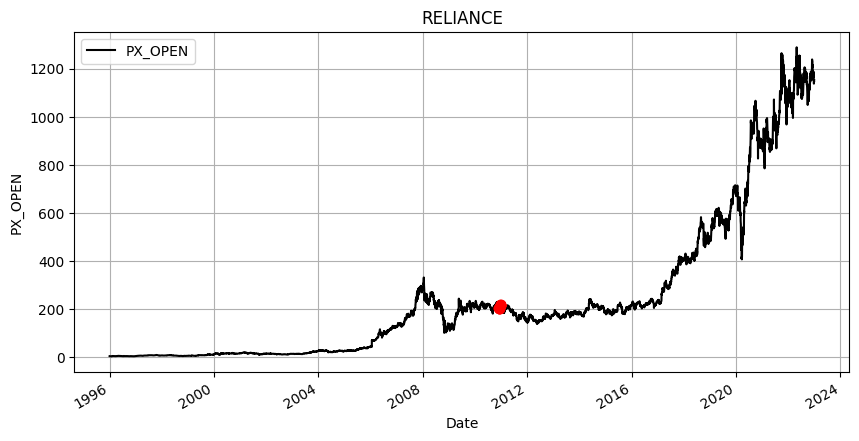

In [22]:
plotPrice('RELIANCE', 'PX_OPEN', None, None, index_map[45])

#Model 1

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,4.5) # Make the default figures a bit bigger
import numpy as np
import random
import pandas as pd
from datetime import datetime
from datetime import date
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [45]:
'''
utoencoder Model: An autoencoder is implemented as a class AnomalyDetector that extends the tf.keras.models.Model class.
The autoencoder is composed of two parts: an encoder and a decoder.
The encoder reduces the dimensionality of the input data, and the decoder restores it to its original shape.
'''

class AnomalyDetectorNN(Model):
    def __init__(self, input_dim=30):
        super(AnomalyDetectorNN, self).__init__()

        # Encoder: Compress input into a smaller representation
        self.encoder = tf.keras.Sequential([
            layers.Dense(128, activation="relu", input_shape=(input_dim,)),  # Input shape added
            layers.Dense(16, activation="relu")
        ])

        # Decoder: Reconstruct input from encoded representation
        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation="relu"),
            layers.Dense(input_dim, activation="sigmoid")  # Ensures output matches input dimension
        ])

    def call(self, x):
        encoded = self.encoder(x)   # Encode input
        decoded = self.decoder(encoded)  # Decode back to original shape
        return decoded

autoencoder = AnomalyDetectorNN(30)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class LSTMAutoencoder(Model):
    def __init__(self, input_dim=30, latent_dim=16):
        super(LSTMAutoencoder, self).__init__()

        # Encoder: Compress input into a smaller representation
        self.encoder = tf.keras.Sequential([
            layers.LSTM(128, activation="relu", return_sequences=True, input_shape=(input_dim, 1)),
            layers.LSTM(latent_dim, activation="relu", return_sequences=False)  # Bottleneck
        ])

        # Decoder: LSTM reconstructing original input
        self.decoder = tf.keras.Sequential([
            layers.RepeatVector(input_dim),  # Expands bottleneck vector across time steps
            layers.LSTM(128, activation="relu", return_sequences=True),
            layers.TimeDistributed(layers.Dense(1))  # Output shape matches input (30,1)
        ])

    def call(self, x):
        encoded = self.encoder(x)  # Compress input into bottleneck representation
        decoded = self.decoder(encoded)  # Reconstruct sequence from bottleneck
        return decoded

# Example usage
input_dim = 30  # Sequence length (time steps)
latent_dim = 8  # Compressed representation

autoencoder = LSTMAutoencoder(input_dim=input_dim, latent_dim=latent_dim)
autoencoder.compile(optimizer='adam', loss='mae')

print(autoencoder.summary())  # Check model structure

Model: "lstm_autoencoder_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_16 (Sequential)           │ (None, 8)                   │          70,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_17 (Sequential)           │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70,944 (277.12 KB)

 Trainable params: 70,944 (277.12 KB)

 Non-trainable params: 0 (0.00 B)

None


In [46]:
'''
The autoencoder model is compiled with the adam optimizer and the mean absolute error (mae) as the loss function.
'''
autoencoder.compile(optimizer='adam', loss='mae')

In [47]:
'''
The function is intended to normalize a given data using MinMaxScaler, with a rolling window of the specified size. It returns the normalized data as a numpy array.
'''
def normalize_window_roll(data, window_size):
    X = []
    index_map = []  # Store the original indices

    for i in range(0,len(data) - window_size,5):
        x_window = data.iloc[i:i+window_size]
        index_map.append(x_window.index)  # Store the indices
        # Normalize the x_window and y_window
        scaler = MinMaxScaler()
        x_window = scaler.fit_transform(np.array(x_window).reshape(-1, 1))

        X.append(x_window)
    X =np.squeeze(np.array(X), axis=2)

    return X, index_map

In [48]:
import numpy as np
import pandas as pd

def split_data(X, index_map, test_start, test_end, val_start, val_end):
    """
    Splits data into train, validation, and test sets based on given date ranges.

    Parameters:
    - X: np.array (N_data x seq_length), the data
    - index_map: list of pd.DatetimeIndex, mapping each index in X to a sequence of dates
    - test_start: datetime.date or pd.Timestamp, start date for test set
    - test_end: datetime.date or pd.Timestamp, end date for test set
    - val_start: datetime.date or pd.Timestamp, start date for validation set
    - val_end: datetime.date or pd.Timestamp, end date for validation set

    Returns:
    - X_train, X_val, X_test: np.array, split data
    - index_train, index_val, index_test: list of pd.DatetimeIndex
    """

    # Convert all date inputs to pd.Timestamp for consistency
    test_start, test_end = pd.Timestamp(test_start), pd.Timestamp(test_end)
    val_start, val_end = pd.Timestamp(val_start), pd.Timestamp(val_end)

    # Extract representative date (first date of each sequence in index_map)
    index_representative = [dates[0] for dates in index_map]

    # Identify test indices
    test_mask = [(date >= test_start) & (date <= test_end) for date in index_representative]
    test_indices = np.where(test_mask)[0]
    X_test = X[test_indices]
    index_test = [index_map[i] for i in test_indices]

    # Identify validation indices
    val_mask = [(date >= val_start) & (date <= val_end) for date in index_representative]
    val_indices = np.where(val_mask)[0]
    X_val = X[val_indices]
    index_val = [index_map[i] for i in val_indices]

    # Remaining data for training
    train_mask = ~np.array(test_mask) & ~np.array(val_mask)
    train_indices = np.where(train_mask)[0]
    X_train = X[train_indices]
    index_train = [index_map[i] for i in train_indices]

    return X_train, X_val, X_test, index_train, index_val, index_test


In [49]:
len(X_train)

1036

In [50]:
#Source: https://www.tensorflow.org/tutorials/generative/autoencoder
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

In [25]:
int(0.2*X.shape[0])

227

<ipython-input-56-87794950fe9e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.dropna(inplace=True) # only 2 nan dates for reliance for eg.


Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - loss: 0.3294 - val_loss: 0.2333
Epoch 2/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.2251 - val_loss: 0.2008
Epoch 3/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.1840 - val_loss: 0.1695
Epoch 4/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.1593 - val_loss: 0.1605
Epoch 5/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.1442 - val_loss: 0.1392
Epoch 6/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.1294 - val_loss: 0.1371
Epoch 7/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.1283 - val_loss: 0.1331
Epoch 8/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.1214 - val_loss: 0.1339
Epoch 9/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 0.1217 - val_loss: 0.1321
Epoch 10/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.1214 - val_loss: 0.1300
Epoch 11/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.1227 - val_loss: 0.1319
Epoch 12/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.1196 - val_

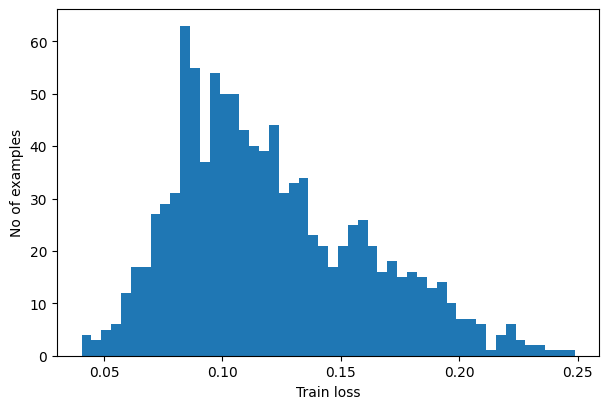

Threshold:  0.1600399484981235
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


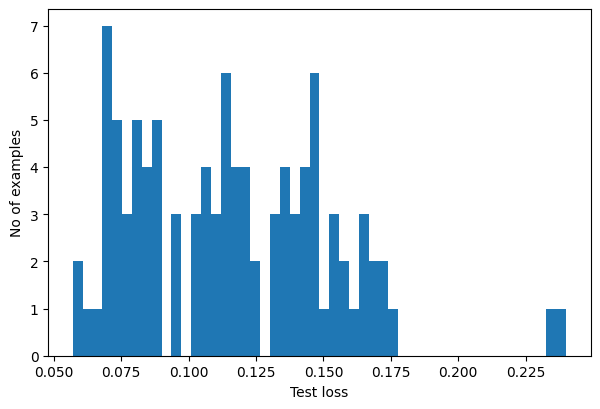

[Timestamp('2019-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00')]


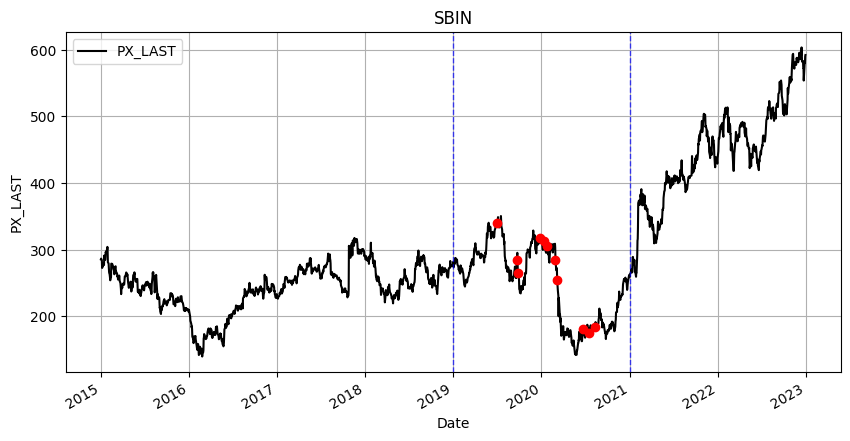

<ipython-input-56-87794950fe9e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.dropna(inplace=True) # only 2 nan dates for reliance for eg.


Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - loss: 0.3313 - val_loss: 0.2245
Epoch 2/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.2330 - val_loss: 0.2247
Epoch 3/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.2231 - val_loss: 0.2195
Epoch 4/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.2092 - val_loss: 0.1795
Epoch 5/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.1690 - val_loss: 0.1569
Epoch 6/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.1538 - val_loss: 0.1513
Epoch 7/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.1502 - val_loss: 0.1497
Epoch 8/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.1522 - val_loss: 0.1538
Epoch 9/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.1549 - val_loss: 0.1441
Epoch 10/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.1449 - val_loss: 0.1376
Epoch 11/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.1371 - val_loss: 0.1326
Epoch 12/80
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.1304 - val_

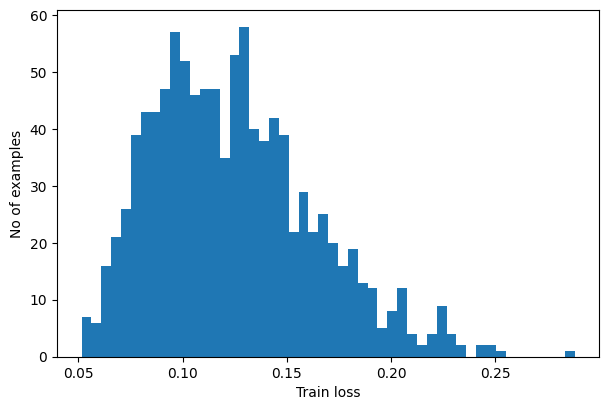

Threshold:  0.16327419512695474
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


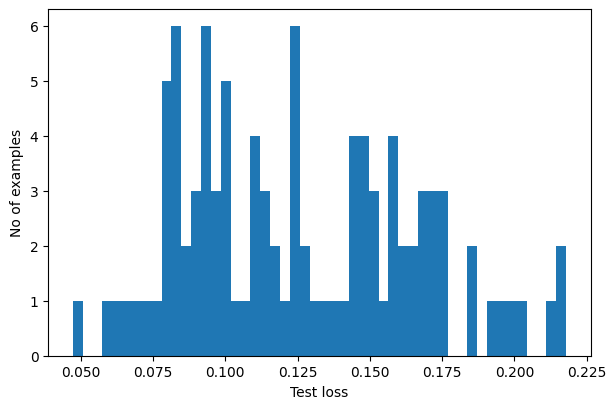

[Timestamp('2019-01-01 00:00:00'), Timestamp('2021-01-01 00:00:00')]


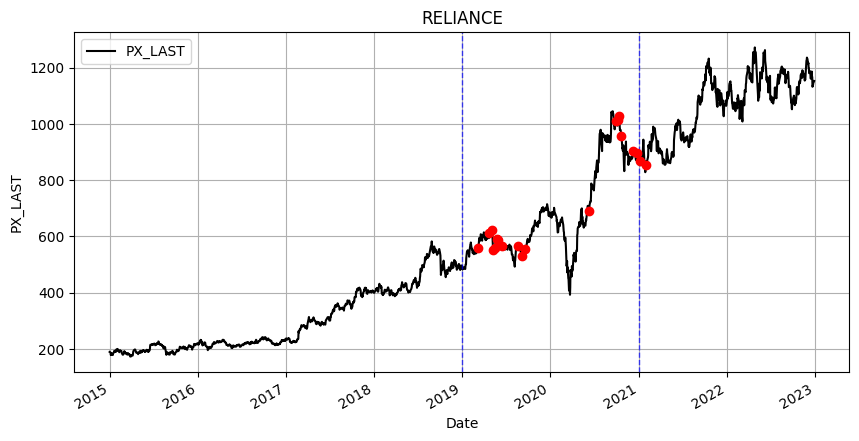

In [56]:
#TICKERS = CURR_UNIVERSE
TICKERS = ['SBIN', 'RELIANCE']
PRICE_TYPE = 'PX_LAST'

for ticker in TICKERS:
  prices = getStockPriceTimeSeries(ticker)[PRICE_TYPE]
  prices.rename('price', inplace=True)
  prices.dropna(inplace=True) # only 2 nan dates for reliance for eg.
  X, index_map = normalize_window_roll(prices,30)
  # train_size = int(0.7*X.shape[0])
  # test_size = int(0.1*X.shape[0])
  # val_size = int(0.2*X.shape[0])


  # X_train = X[:train_size]
  # X_val = X[train_size+test_size:train_size+val_size+test_size]
  # X_test = X[train_size:train_size+test_size]
  # val_index_offset = train_size + test_size
  # test_index_offset = train_size

  # X_train = X[:train_size]
  # X_val = X[train_size:train_size+val_size]
  # X_test = X[train_size+val_size:train_size+test_size+val_size]

  # val_index_offset = train_size
  # test_index_offset = train_size + val_size


  startTest = date(2019, 1, 1)
  endTest = date(2021, 1, 1)

  startVal = date(2014, 1, 1)
  endVal = date(2018, 1, 1)

  X_train, X_val, X_test, index_train, index_val, index_test = split_data(X, index_map, startTest, endTest, startVal, endVal )

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min')

  #autoencoder = AnomalyDetectorNN(30)
  autoencoder = LSTMAutoencoder(input_dim=input_dim, latent_dim=latent_dim)
  autoencoder.compile(optimizer='adam', loss='mae')

  history = autoencoder.fit(X_train,X_train, epochs=80,
                      validation_data=(X_val, X_val),
                      batch_size=16,
                      callbacks=[early_stopping])

  reconstructions = autoencoder.predict(X_train)
  train_loss = tf.keras.losses.mae(reconstructions, X_train)

  plt.hist(train_loss[None,:], bins=50)
  plt.xlabel("Train loss")
  plt.ylabel("No of examples")
  plt.show()

  threshold = np.mean(train_loss) + np.std(train_loss)
  #threshold = np.max(train_loss)
  print("Threshold: ", threshold)

  reconstructions = autoencoder.predict(X_test)
  test_loss = tf.keras.losses.mae(reconstructions, X_test)

  plt.hist(test_loss[None, :], bins=50)
  plt.xlabel("Test loss")
  plt.ylabel("No of examples")
  plt.show()

  preds = predict(autoencoder, X_test, threshold)

  anomalousIndexIds  = np.where(preds == False)[0]
  #anomalousIndexIds = [ int(test_index_offset + id) for id in anomalousIndexIds ]

  #dotDates = [index_map[i][-1] for i in anomalousIndexIds]
  dotDates = [index_test[i][-1] for i in anomalousIndexIds]
  #plotPrice(ticker, PRICE_TYPE, date(2015, 1, 1), None, dotDates, lineDates=[index_map[val_index_offset][0], index_map[test_index_offset][0]], saveSuffix=autoencoder.__class__.__name__)
  plotPrice(ticker, PRICE_TYPE, date(2015, 1, 1), None, dotDates, lineDates=[startTest, endTest], saveSuffix=autoencoder.__class__.__name__)

In [6]:
TICKER = 'SBIN'
PRICE_TYPE = 'PX_LAST'
prices = getStockPriceTimeSeries(TICKER, start=date(2010, 1, 1))[PRICE_TYPE]
prices.rename('price', inplace=True)
prices.dropna(inplace=True) # only 2 nan dates for reliance for eg.

NameError: name 'getStockPriceTimeSeries' is not defined

In [7]:
# should we smoothen the data ?
X, index_map = normalize_window_roll(prices,30)

NameError: name 'prices' is not defined

In [532]:
print(X.shape)
print(prices.shape)
print(len(index_map))

(640, 30)
(3226,)
640


In [533]:
train_size = int(0.7*X.shape[0])
test_size = int(0.1*X.shape[0])
val_size = int(0.2*X.shape[0])

X_train = X[:train_size]
X_val = X[train_size+test_size:train_size+val_size+test_size]
X_test = X[train_size:train_size+test_size]

val_index_offset = train_size + test_size
test_index_offset = train_size
#X_val = X[train_size+test_size:train_size+test_size+val_size]

In [534]:
'''
Training the model: The autoencoder is trained using the stock market data using the fit function.
An EarlyStopping callback is added to stop the training if the validation loss does not improve for 2 consecutive epochs.
'''
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min')
autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(X_train,X_train, epochs=80,
                    validation_data=(X_val, X_val),
                    batch_size=16,
                    callbacks=[early_stopping])

Epoch 1/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0653 - val_loss: 0.0665
Epoch 2/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0632 - val_loss: 0.0647
Epoch 3/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0631 - val_loss: 0.0634
Epoch 4/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0615 - val_loss: 0.0650
Epoch 5/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0606 - val_loss: 0.0633
Epoch 6/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0610 - val_loss: 0.0649
Epoch 7/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0617 - val_loss: 0.0642


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


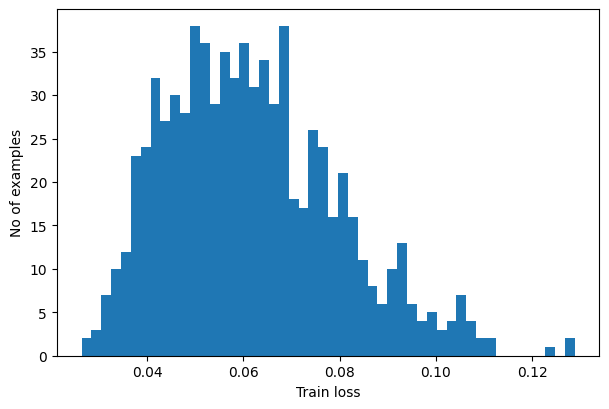

In [505]:
#Source: https://www.tensorflow.org/tutorials/generative/autoencoder
reconstructions = autoencoder.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions, X_train)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [506]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.07979709030643815


In [507]:
np.mean(train_loss)

np.float64(0.061887538096928936)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


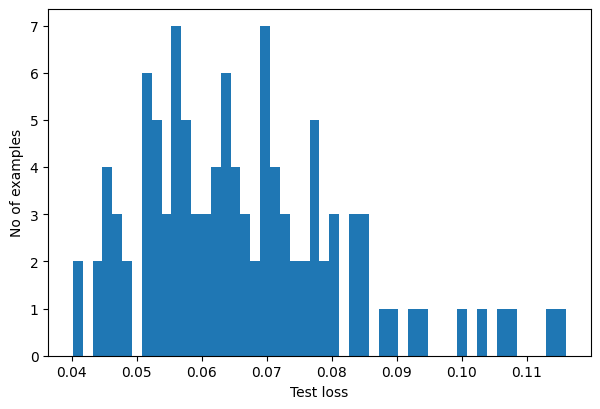

In [508]:
reconstructions = autoencoder.predict(X_test)
test_loss = tf.keras.losses.mae(reconstructions, X_test)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [510]:
preds = predict(autoencoder, X_test, threshold)

In [511]:
preds

<tf.Tensor: shape=(108,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])>

In [512]:
anomalous_test_data = X_test[np.where(preds==False)]

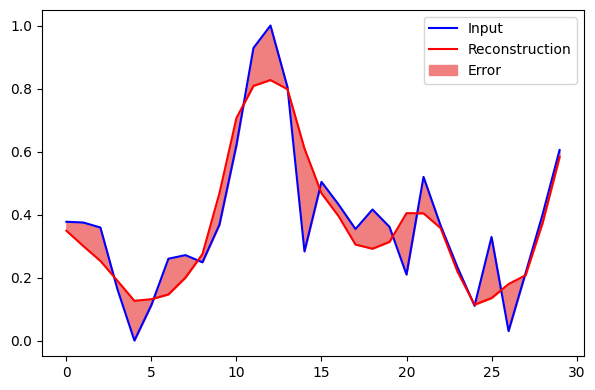

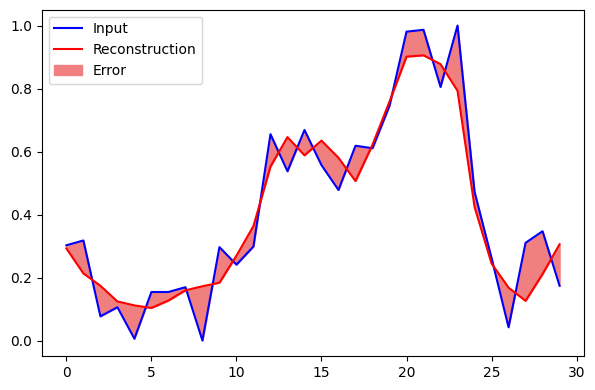

IndexError: index 20 is out of bounds for axis 0 with size 19

In [513]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

for p in [1,10,20]:
  plt.plot(anomalous_test_data[p], 'b')
  plt.plot(np.arange(0,X.shape[1]),decoded_data[p], 'r')
  plt.fill_between(np.arange(X.shape[1]), decoded_data[p], anomalous_test_data[p], color='lightcoral')
  plt.legend(labels=["Input", "Reconstruction", "Error"])
  plt.show()

#Visualize on original price plot

In [515]:
anomalousIndexIds  = np.where(preds == False)[0]
anomalousIndexIds = [ int(test_index_offset + id) for id in anomalousIndexIds ]

In [524]:
#dotDates = [date for i in anomalousIndexIds for date in index_map[i]]
dotDates = [index_map[i][0] for i in anomalousIndexIds]

In [518]:
dotDates

[Timestamp('2016-06-30 00:00:00'),
 Timestamp('2016-08-22 00:00:00'),
 Timestamp('2016-08-29 00:00:00'),
 Timestamp('2016-09-06 00:00:00'),
 Timestamp('2016-09-14 00:00:00'),
 Timestamp('2016-09-21 00:00:00'),
 Timestamp('2016-10-21 00:00:00'),
 Timestamp('2016-11-11 00:00:00'),
 Timestamp('2017-02-07 00:00:00'),
 Timestamp('2017-03-30 00:00:00'),
 Timestamp('2017-04-17 00:00:00'),
 Timestamp('2017-10-24 00:00:00'),
 Timestamp('2017-10-31 00:00:00'),
 Timestamp('2017-11-07 00:00:00'),
 Timestamp('2017-11-14 00:00:00'),
 Timestamp('2017-12-12 00:00:00'),
 Timestamp('2018-03-05 00:00:00'),
 Timestamp('2018-03-19 00:00:00'),
 Timestamp('2018-04-04 00:00:00')]

[Timestamp('2018-06-21 00:00:00'), Timestamp('2016-04-21 00:00:00')]


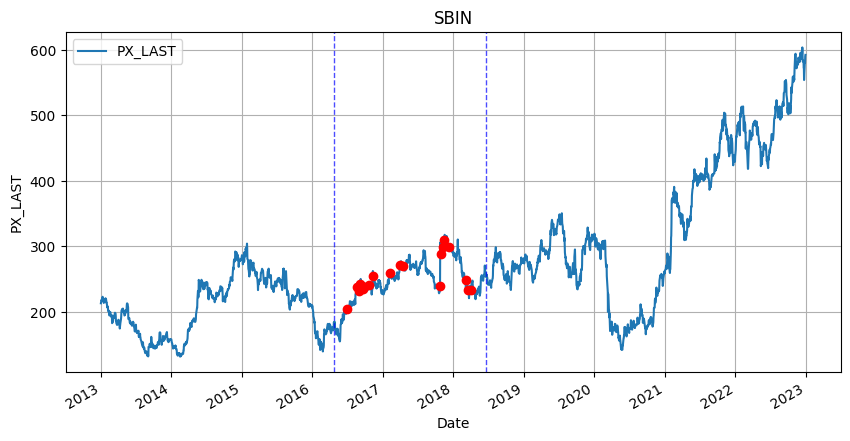

In [526]:
plotPrice(TICKER, 'PX_LAST', date(2013, 1, 1), None, dotDates, lineDates=[index_map[val_index_offset][0], index_map[test_index_offset][0]])

In [413]:
ticker

nan

In [255]:
prices.index[test_index_offset]

Timestamp('2000-11-27 00:00:00')

In [235]:
val_index_offset

933

In [236]:
test_index_offset

1199